##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [348]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [349]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [350]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [352]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [353]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [354]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [355]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


###  **Task 1 Solution**
Columns definintions:
* **'X'** is latitude of the crime location.

*   **'Y'** is longitude of the crime location.
**'Area_Command'** is the police designation of the bureau of the operation.
* 'NIBRSOffenseCode' is the assocaited with each unique classification code for the crime committed.
* 'DayOfWeek' is the day of the week as an integer.
* 'Time' is the hour of the day
'DayOfWeek' is the day of the week as an integer.*italicized text*
* 'VictimCount' is the number of people involved in the accident

In [438]:
# display a few rows of dataframe
print(df[0:5])

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


The input variables are 'X','Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time'.

The output variable is 'VictimCount'.

The range of values for each column can be found by indentifying the smallest and largest vlaue within each column:


In [439]:
# loop to print range of values for every colum
features = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']
for i in range(0, len(features)):
  min_val = min(df.iloc[:,i])
  max_val = max(df.iloc[:,i])
  print("Range of", features[i], "column: ", min_val, "to ", max_val)


Range of X column:  -116.0 to  -114.6255705
Range of Y column:  35.0684190000001 to  37.0000000000001
Range of Area_Command column:  0 to  11
Range of NIBRSOffenseCode column:  0 to  2
Range of DayOfWeek column:  0 to  6
Range of Time column:  0 to  23
Range of VictimCount column:  0 to  6


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

###  **Task 2 Solution**

In [440]:
# initialize custome dataset model
class CrimeDataset(Dataset):
  def __init__(self, inputs, outputs):
    self.inputs = inputs
    self.outputs = outputs
    self.length = len(outputs)
  def __len__(self):
    return self.length
  def __getitem__(self, i):
    return self.inputs[i], self.outputs[i]



In [460]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import TensorDataset

batch_size = 32
# define features and targets
inputs_data = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values
output_data = df[['VictimCount']].values
# split data into training and testing data
train_inputs, test_inputs, train_output, test_output = train_test_split(inputs_data, output_data,test_size = 0.3,random_state = 1)

# turn dataframe into dataset using custom datatset model
train_data = CrimeDataset(train_inputs, train_output)
test_data = CrimeDataset(test_inputs, test_output)
# add datasets to dataloader
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=True,)
# check shape of testing and training batches
print("-----Training-----")
for batch_input, batch_output in train_loader:
    print("Input Shape:", batch_input.shape)
    print("Output Shape:", batch_output.shape)
    break
print("-----Test-----")
for batch_input, batch_output in test_loader:
    print("Input Shape:", batch_input.shape)
    print("Output Shape:", batch_output.shape)
    break

-----Training-----
Input Shape: torch.Size([32, 6])
Output Shape: torch.Size([32, 1])
-----Test-----
Input Shape: torch.Size([32, 6])
Output Shape: torch.Size([32, 1])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

###  **Task 3 Solution**

In [442]:
# Define loss function
loss_funct = nn.MSELoss()

In [443]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

The size of the ouput should be the [32, 1].

In [445]:
# initialize the learning model
from tensorflow import keras

class CrimeModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.line1 = nn.Linear(6, 1, True)
    self.relu1 = nn.ReLU()
  def forward(self, x):
    x = self.line1(x)
    return x

model = CrimeModel()


I chose to build

In [446]:
from sklearn.metrics import mean_squared_error
num_epochs = 10
# trainig loop
for epoch in range(num_epochs):
    for batch_inputs, batch_output in train_loader:
      optimizer.zero_grad()
      train_predicts = model(batch_inputs.float())
      loss = loss_funct(train_predicts, batch_output.float())
      loss.backward()
      optimizer.step()
    # calculating and print MSE for each epoch
    mse = 0
    for batch_inputs, batch_output in test_loader:
      test_predict = model(batch_inputs.float())
      mse = loss_funct(test_predict,batch_output.float()).item()
    print("MSE error at epoch", epoch, ": ", mse )

MSE error at epoch 0 :  2.060438871383667
MSE error at epoch 1 :  1.887529730796814
MSE error at epoch 2 :  1.9456232786178589
MSE error at epoch 3 :  3.103287935256958
MSE error at epoch 4 :  1.3437120914459229
MSE error at epoch 5 :  2.149050712585449
MSE error at epoch 6 :  4.082233905792236
MSE error at epoch 7 :  4.1467742919921875
MSE error at epoch 8 :  2.101545810699463
MSE error at epoch 9 :  1.7323215007781982


## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

###  **Task 4 Solution**

The number of classes on the output data can be determined by find the range of values for victim count. Each value in that range will become a class number. The vlaue range for victim count for the data provided was 0 to 6.

In [447]:
# Define loss function
loss = nn.CrossEntropyLoss()

The loss function for this classification problem is cross-entry loss. This loss function measures the models correct prediction.

In [448]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [452]:
# initialize model
from tensorflow import keras

class CrimeModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.line1 = nn.Linear(6, 1, True)
    self.relu1 = nn.Sigmoid()
  def forward(self, x):
    x = self.line1(x)
    return x


model = CrimeModel()


I chose to build

In [467]:
from sklearn.metrics import mean_squared_error
num_epochs = 10
# trainig loop
for epoch in range(num_epochs):
    for batch_inputs, batch_output in train_loader:
      optimizer.zero_grad()
      train_predicts = model(batch_inputs.float())
      loss = loss_funct(train_predicts, batch_output.float())
      loss.backward()
      optimizer.step()
    # calculating and print accuracy for each epoch
    acc = 0
    i = 0
    for batch_inputs, batch_output in test_loader:
      test_predict = model(batch_inputs.float())
      i+= 1
      if batch_output[i].item() != 0:
        acc = (test_predict[i].item() / batch_output[i].item())
    print("Accuracy at epoch", epoch, ": ", acc)

Accuracy at epoch 0 :  -31.79110336303711
Accuracy at epoch 1 :  -33.10005187988281
Accuracy at epoch 2 :  -27.951467514038086
Accuracy at epoch 3 :  -14.333639144897461
Accuracy at epoch 4 :  -32.663482666015625
Accuracy at epoch 5 :  -29.44942855834961
Accuracy at epoch 6 :  -9.527363459269205
Accuracy at epoch 7 :  -30.311870574951172
Accuracy at epoch 8 :  -34.580318450927734
Accuracy at epoch 9 :  -29.292858123779297


The best accuracy is ...

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

###  **Task 5 Solution**

I experienced some difficulty with task 3 and 4. Although it was not completed up to standard, It was best to put something

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


###  **Task 6 Solution**

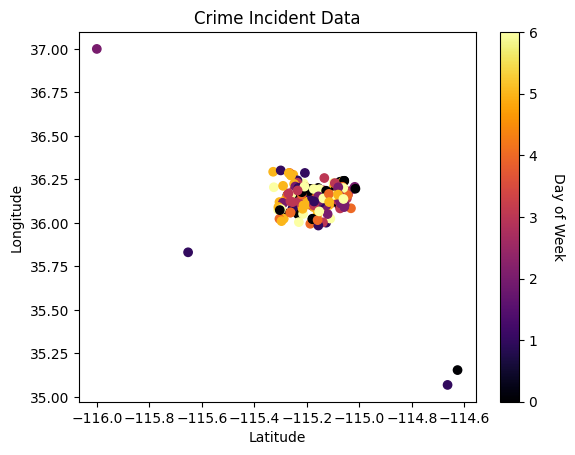

In [ ]:
import matplotlib.pyplot as plt
plt.title("Crime Incident Data")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.scatter(x = df['X'], y = df['Y'], c = df['DayOfWeek'], cmap = 'inferno')
plt.colorbar().set_label("Day of Week", labelpad=20, rotation=270)
plt.show()

Excluding a few outliers, the data points seem to be consentricated in a localized area regardless of day.  

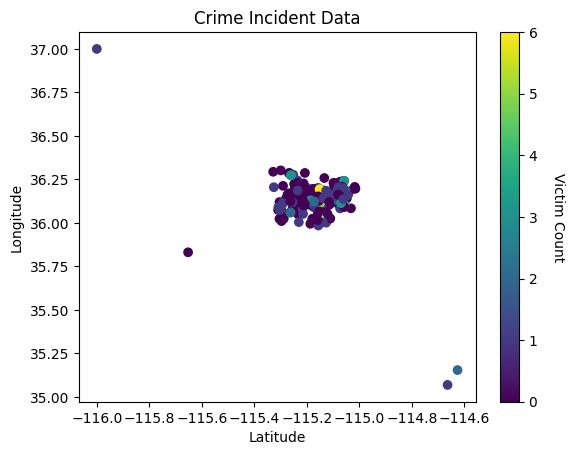

In [ ]:
import matplotlib.pyplot as plt
plt.title("Crime Incident Data")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.scatter(x = df['X'], y = df['Y'], c = df['VictimCount'])
plt.colorbar().set_label("Victim Count", labelpad=20, rotation=270)
plt.show()

In [ ]:
df.sort_values('DayOfWeek')
days = {5: 'Monday', 2: 'Tuesday', 6: 'Wednesday', 1: 'Thursday', 0: 'Friday', 3: 'Saturday', 4: 'Sunday'}
for key in days:
  print("Crimes reported on", days[key],": ", df['DayOfWeek'].value_counts()[key])

Crimes reported on Monday :  43
Crimes reported on Tuesday :  32
Crimes reported on Wednesday :  28
Crimes reported on Thursday :  37
Crimes reported on Friday :  40
Crimes reported on Saturday :  44
Crimes reported on Sunday :  51


The weekend, Saturday and Sunday, are the days that had crimes reported most frequently.